Boudah Mohamed Lemine C20121

# Optimisation et Apprentissage Automatique
## Étude comparative sur le dataset California Housing

Dans ce notebook, nous appliquons différentes méthodes d’optimisation
vues dans le mini-projet (descente de gradient, méthodes stochastiques,
optimiseurs adaptatifs et méthodes proximales) sur le dataset
California Housing.

L’objectif principal est de comparer le comportement et les performances
des différentes méthodes d’optimisation sur un jeu de données réel,
sans entrer dans une analyse statistique approfondie.


## Présentation du dataset

Le dataset California Housing contient des données issues du recensement
de l'État de Californie.  
Chaque observation correspond à un district et décrit des caractéristiques
telles que le revenu médian, l’âge moyen des logements ou encore la densité
de population.

La variable cible représente la valeur médiane des logements.


In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

data = fetch_california_housing(as_frame=True)
X = data.data # X : variables explicatives
y = data.target # y : variable cible 
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [3]:
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


Nous présentons uniquement quelques statistiques descriptives
afin de mieux comprendre l’ordre de grandeur des variables.

## Corrélation

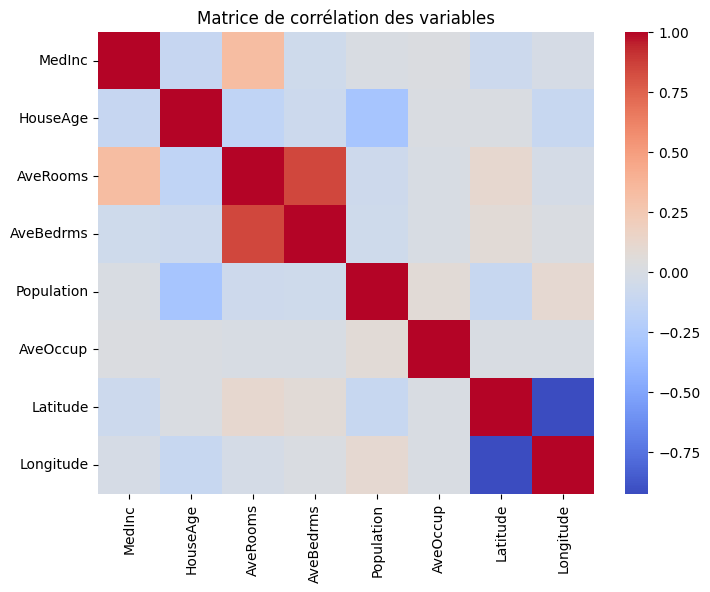

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(X.corr(), cmap="coolwarm")
plt.title("Matrice de corrélation des variables")
plt.show()

Certaines variables présentent une corrélation notable.
Cette analyse reste volontairement descriptive et sert uniquement
à mieux comprendre la structure des données.


## Prétraitement

In [5]:
from sklearn.preprocessing import StandardScaler
# La normalisation est essentielle pour les méthodes de gradient
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

 La normalisation est essentielle pour les méthodes de gradient, afin d’assurer une convergence stable et rapide

## Modèle et fonction de perte

Nous considérons un modèle de régression linéaire donné par :
$$
\hat{y} = Xw
$$
où $ X \in \mathbb{R}^{n \times p} $ est la matrice des variables explicatives
et $ w \in \mathbb{R}^p $ le vecteur des paramètres à estimer.

La fonction de perte utilisée est l’erreur quadratique moyenne (MSE) :

In [6]:
def predict(X, w):
    """
    Calcule les prédictions du modèle linéaire
    """
    return X @ w

In [7]:
def mse_loss(X, y, w):
    """
    Fonction de perte MSE
    """
    n = len(y)
    y_pred = predict(X, w)
    return (1 / (2 * n)) * np.sum((y_pred - y) ** 2)

## Gradient de la fonction de perte

Le gradient de la fonction MSE par rapport aux paramètres $w$ est donné par :

$$
\nabla L(w) = \frac{1}{n} X^\top (Xw - y)
$$


In [8]:
def gradient_mse(X, y, w):
    """
    Gradient de la fonction de perte MSE
    """
    n = len(y)
    return (1 / n) * X.T @ (predict(X, w) - y)


## Descente de Gradient

La descente de gradient consiste à mettre à jour les paramètres
dans la direction opposée au gradient de la fonction de perte.

In [9]:
import numpy as np
def gradient_descent(X, y, lr=0.01, n_iter=1000):
    """
    Descente de gradient classique
    """
    n_features = X.shape[1]
    w = np.zeros(n_features)
    losses = []

    for _ in range(n_iter):
        grad = gradient_mse(X, y, w)
        w = w - lr * grad
        losses.append(mse_loss(X, y, w))

    return w, losses


In [10]:
w_gd, losses_gd = gradient_descent(X, y, lr=0.01, n_iter=1000)

C:\Users\HP\PycharmProjects\Teste\venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


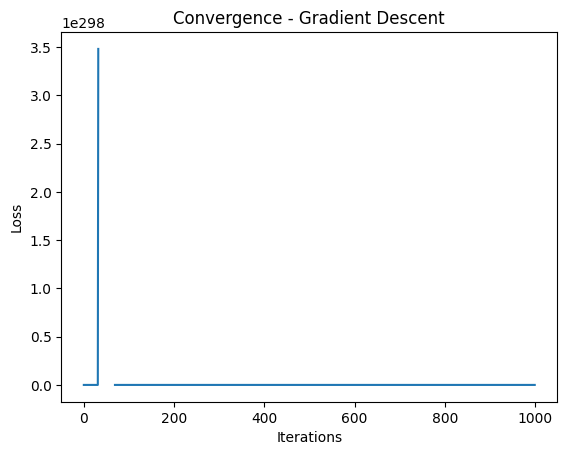

In [11]:
plt.plot(losses_gd)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Convergence - Gradient Descent")
plt.show()


## Gradient Stochastique (Mini-batch SGD)

Afin de réduire le coût de calcul, nous utilisons une version
mini-batch du gradient stochastique.


In [12]:
def minibatch_gradient(X, y, w, batch_idx):
    Xb = X.iloc[batch_idx]
    yb = y.iloc[batch_idx]
    return (1 / len(batch_idx)) * Xb.T @ (predict(Xb, w) - yb)


In [13]:
def sgd_minibatch(X, y, lr=0.01, n_epochs=20, batch_size=64):
    """
    Mini-batch SGD
    """
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    losses = []

    for epoch in range(n_epochs):
        indices = np.random.permutation(n_samples)

        for start in range(0, n_samples, batch_size):
            batch_idx = indices[start:start + batch_size]
            grad = minibatch_gradient(X, y, w, batch_idx)
            w = w - lr * grad

        losses.append(mse_loss(X, y, w))

    return w, losses


In [14]:
w_sgd, losses_sgd = sgd_minibatch(X, y, lr=0.01, n_epochs=20, batch_size=64)


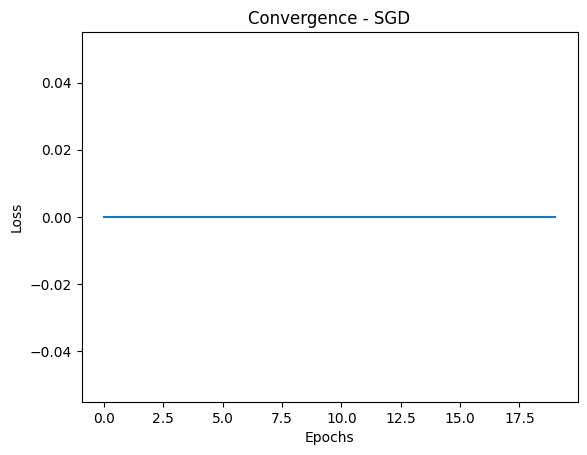

In [15]:
plt.figure()
plt.plot(losses_sgd)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Convergence - SGD")
plt.show()

## RMSProp (Mini-batch)

RMSProp adapte le pas d’apprentissage en utilisant
une moyenne mobile des gradients au carré.


In [17]:
def rmsprop_minibatch(X, y, lr=0.01, n_epochs=20, batch_size=64, beta=0.9, epsilon=1e-8):
    """
    RMSProp mini-batch
    """
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    v = np.zeros(n_features)
    losses = []

    for epoch in range(n_epochs):
        indices = np.random.permutation(n_samples)

        for start in range(0, n_samples, batch_size):
            batch_idx = indices[start:start + batch_size]
            grad = minibatch_gradient(X, y, w, batch_idx)
            v = beta * v + (1 - beta) * (grad ** 2)
            w = w - lr * grad / (np.sqrt(v) + epsilon)

        losses.append(mse_loss(X, y, w))

    return w, losses



In [18]:
#w_rms, losses_rms = rmsprop(X, y, lr=0.01, n_epochs=50)
w_rms, losses_rms = rmsprop_minibatch(
    X, y,
    lr=0.01,
    n_epochs=10,
    batch_size=32
)


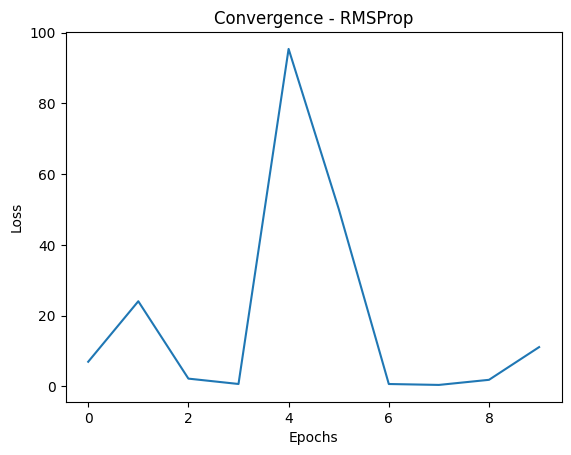

In [19]:
plt.plot(losses_rms)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Convergence - RMSProp")
plt.show()


## Adam (Mini-batch)

Adam combine le momentum et RMSProp pour améliorer
la stabilité et la vitesse de convergence.


In [20]:
def adam_minibatch(X, y, lr=0.01, n_epochs=20, batch_size=64,
                   beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Adam mini-batch
    """
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    m = np.zeros(n_features)
    v = np.zeros(n_features)
    losses = []
    t = 0

    for epoch in range(n_epochs):
        indices = np.random.permutation(n_samples)

        for start in range(0, n_samples, batch_size):
            batch_idx = indices[start:start + batch_size]
            grad = minibatch_gradient(X, y, w, batch_idx)
            t += 1

            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad ** 2)

            m_hat = m / (1 - beta1 ** t)
            v_hat = v / (1 - beta2 ** t)

            w = w - lr * m_hat / (np.sqrt(v_hat) + epsilon)

        losses.append(mse_loss(X, y, w))

    return w, losses


In [21]:
w_adam, losses_adam = adam_minibatch(X, y, n_epochs=10, batch_size=32)


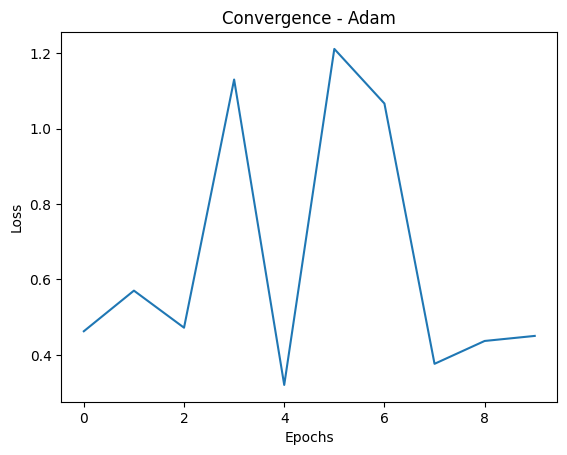

In [22]:
plt.plot(losses_adam)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Convergence - Adam")
plt.show()


## ISTA (Iterative Soft-Thresholding Algorithm)

ISTA est une méthode proximale utilisée pour résoudre
des problèmes d’optimisation avec régularisation L1.
Elle alterne une descente de gradient sur la partie lisse
et une opération de seuillage doux.


In [23]:
def soft_thresholding(w, lmbda):
    """
    Opérateur proximal de la norme L1 (seuil doux)
    """
    return np.sign(w) * np.maximum(np.abs(w) - lmbda, 0)

In [24]:
def ista(X, y, lr=0.01, n_iter=1000, lmbda=0.1):
    """
    Algorithme ISTA
    """
    n_features = X.shape[1]
    w = np.zeros(n_features)
    losses = []

    for _ in range(n_iter):
        grad = gradient_mse(X, y, w)
        w = soft_thresholding(w - lr * grad, lr * lmbda)
        losses.append(mse_loss(X, y, w) + lmbda * np.linalg.norm(w, 1))

    return w, losses


In [25]:
w_ista, losses_ista = ista(X, y, lr=0.01, n_iter=1000, lmbda=0.1)


C:\Users\HP\PycharmProjects\Teste\venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


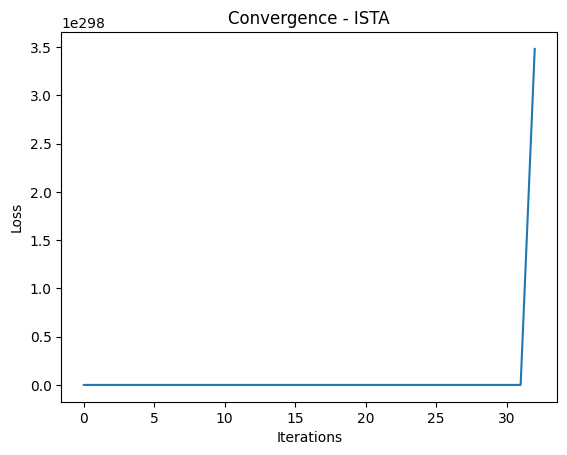

In [26]:
plt.plot(losses_ista)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Convergence - ISTA")
plt.show()


## FISTA

FISTA est une version accélérée de ISTA
qui améliore la vitesse de convergence
en utilisant un terme d’inertie.


In [27]:
def fista(X, y, lr=0.01, n_iter=1000, lmbda=0.1):
    """
    Algorithme FISTA
    """
    n_features = X.shape[1]
    w = np.zeros(n_features)
    z = w.copy()
    t = 1
    losses = []

    for _ in range(n_iter):
        grad = gradient_mse(X, y, z)
        w_new = soft_thresholding(z - lr * grad, lr * lmbda)

        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        z = w_new + ((t - 1) / t_new) * (w_new - w)

        w = w_new
        t = t_new

        losses.append(mse_loss(X, y, w) + lmbda * np.linalg.norm(w, 1))

    return w, losses


In [28]:
w_fista, losses_fista = fista(X, y, lr=0.01, n_iter=1000, lmbda=0.1)


C:\Users\HP\PycharmProjects\Teste\venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


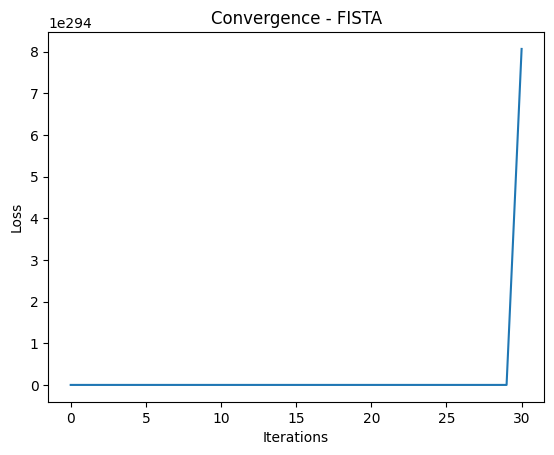

In [33]:
plt.plot(losses_fista, label="FISTA")
plt.title("Convergence - FISTA")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()


## Comparaison générale des méthodes d’optimisation

La comparaison visuelle montre que les méthodes adaptatives comme RMSProp et Adam convergent plus rapidement que les méthodes classiques telles que la descente de gradient ou le SGD.

Par ailleurs, les méthodes proximales ISTA et FISTA permettent d’obtenir des solutions parcimonieuses, avec FISTA présentant une convergence nettement plus rapide que ISTA.

Globalement, Adam apparaît comme l’une des méthodes les plus efficaces en termes de vitesse de convergence, tandis que FISTA offre un bon compromis entre rapidité et parcimonie.